In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [3]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [4]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [5]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 3) array of binary states into (N, M) indices in [0..7].

    Mapping:
      - [a, b, c] are binary bits (0 or 1), forming a 3-bit number: a*4 + b*2 + c
      - NaN-safe: if any of the 3 elements is NaN, output is NaN

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 3).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M) with values in [0..7] or NaN.
    """
    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 3:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 3).")

    nan_mask = np.isnan(all_state_array).any(axis=-1)
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    valid_mask = ~nan_mask
    valid_data = all_state_array[valid_mask]  # shape (?, 3)

    a = valid_data[:, 0]
    b = valid_data[:, 1]
    c = valid_data[:, 2]

    result = (a * 4 + b * 2 + c).astype(float)
    indexed_states[valid_mask] = result

    return indexed_states


In [6]:
import numpy as np
from tqdm import tqdm

def calculate_comform_p(traj):
    """
    Calculates the cumulative conformational state population and standard error over time.

    Parameters
    ----------
    traj : np.ndarray
        A 1D array of shape (timesteps,), where each value is an integer in [0, 7]
        representing the conformational state at that time.

    Returns
    -------
    conform_all_population : np.ndarray
        Array of shape (8, timesteps) — cumulative population per conformation.

    conform_all_population_err : np.ndarray
        Array of same shape — standard error per conformation.
    """
    traj = np.asarray(traj)
    n_time = traj.shape[0]
    conform_num = 8  # 8 possible conformational states

    conform_all_population = np.zeros((conform_num, n_time), dtype=float)
    conform_all_population_err = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in tqdm(range(conform_num), desc="Calculating"):
        match_mask = (traj == conform_state).astype(int)  # shape: (n_time,)
        cumulative_count = np.cumsum(match_mask)          # shape: (n_time,)

        sample_counts = np.arange(1, n_time + 1)          # shape: (n_time,)
        p = cumulative_count / sample_counts              # shape: (n_time,)
        se = np.sqrt(p * (1 - p) / sample_counts)         # shape: (n_time,)

        conform_all_population[conform_state] = p
        conform_all_population_err[conform_state] = se

    print('Conform population shape:', conform_all_population.shape)
    print('Conform population error shape:', conform_all_population_err.shape)

    return conform_all_population, conform_all_population_err


## The Trans Population overtime Plot

In [7]:
omega_all_state = []

for i in range(6):
    omega_state = np.array(Data.load(f'omega_data/omegas_state{i}.pkl').array_list)
    omega_all_state.append(omega_state)

omega_all_state = np.array(omega_all_state)
omega_all_state.shape


(6, 600030, 3)

In [8]:
ntraj = len(omega_all_state)
print('np.array(omega_all_state).shape', np.array(omega_all_state).shape)

cistrans = omega2cistrans(omega_all_state)
print('cistrans.shape', cistrans.shape)

cistrans[0, :10, :]

np.array(omega_all_state).shape (6, 600030, 3)


cistrans.shape (6, 600030, 3)


array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 0, 1],
       [1, 0, 1]])

In [9]:
# Convert the cistrans into 8 state [0...7]

all_comform = state_to_index_vectorized(cistrans)
all_comform.shape

(6, 600030)

In [10]:
conform_thermo_all_population = []
conform_thermo_all_population_err = []

for thermo in range(6):
    traj = all_comform[thermo]
    conform_all_population, conform_all_population_err = calculate_comform_p(traj)
    
    conform_thermo_all_population.append(conform_all_population)
    conform_thermo_all_population_err.append(conform_all_population_err)

conform_thermo_all_population = np.array(conform_thermo_all_population)
conform_thermo_all_population_err = np.array(conform_thermo_all_population_err)

print('trans_all_population.shape', conform_thermo_all_population.shape)
print('conform_thermo_all_population_err.shape', conform_thermo_all_population_err.shape)

Calculating: 100%|██████████| 8/8 [00:00<00:00, 50.71it/s]


Conform population shape: (8, 600030)
Conform population error shape: (8, 600030)


Calculating: 100%|██████████| 8/8 [00:00<00:00, 46.94it/s]


Conform population shape: (8, 600030)
Conform population error shape: (8, 600030)


Calculating: 100%|██████████| 8/8 [00:00<00:00, 49.48it/s]


Conform population shape: (8, 600030)
Conform population error shape: (8, 600030)


Calculating: 100%|██████████| 8/8 [00:00<00:00, 59.51it/s]


Conform population shape: (8, 600030)
Conform population error shape: (8, 600030)


Calculating: 100%|██████████| 8/8 [00:00<00:00, 59.07it/s]


Conform population shape: (8, 600030)
Conform population error shape: (8, 600030)


Calculating: 100%|██████████| 8/8 [00:00<00:00, 54.16it/s]


Conform population shape: (8, 600030)
Conform population error shape: (8, 600030)
trans_all_population.shape (6, 8, 600030)
conform_thermo_all_population_err.shape (6, 8, 600030)


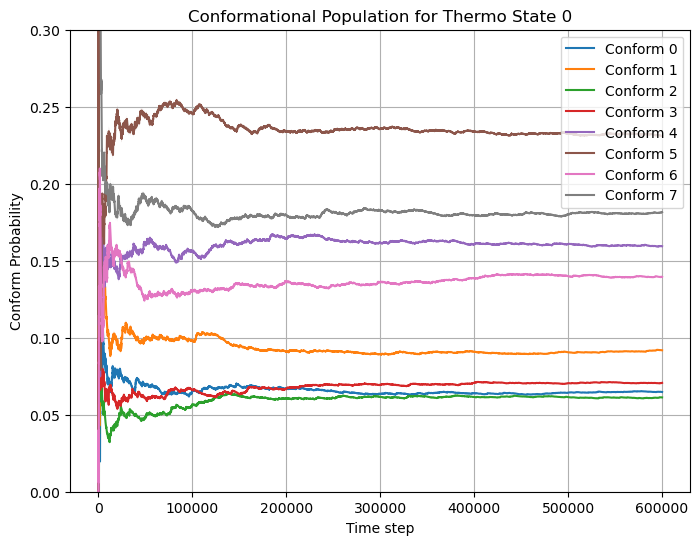

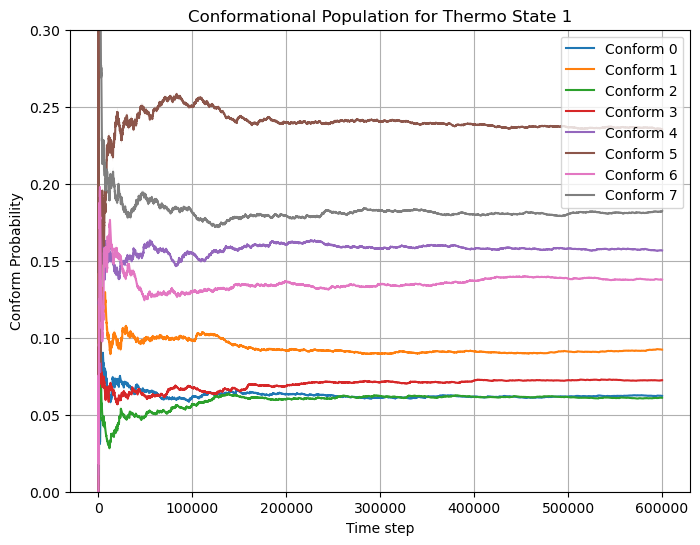

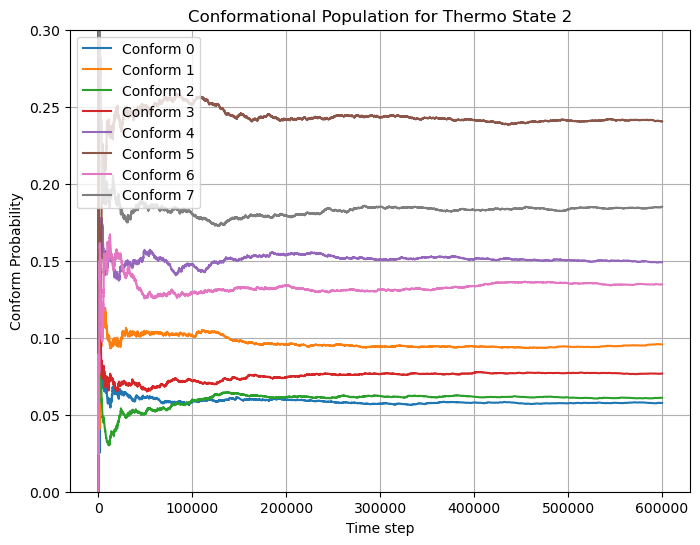

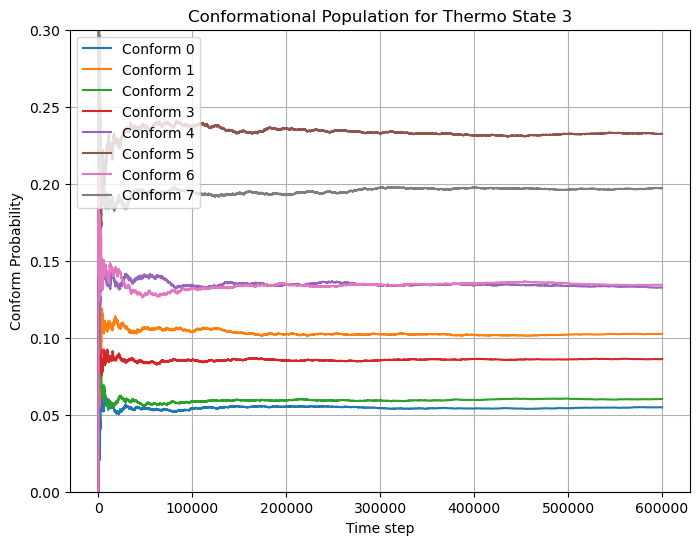

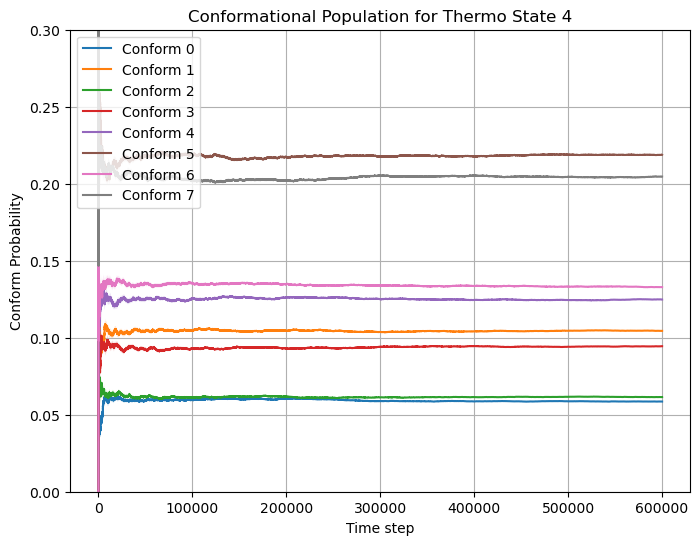

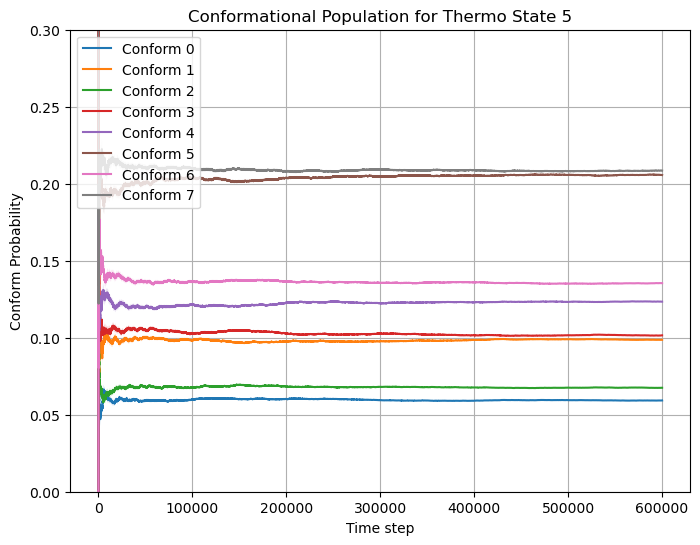

In [11]:
thermo_num = 6
conform_num = 8

for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(8, 6))
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        yerr = conform_thermo_all_population_err[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        plt.plot(x, y, label=f'Conform {conform}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    plt.title(f'Conformational Population for Thermo State {thermo}')
    plt.xlabel('Time step')
    plt.ylabel('Conform Probability')
    plt.ylim(0, 0.3)
    plt.grid(True)
    plt.legend(loc="best")
    #plt.tight_layout()
    plt.show()


## Error Over Times

In [12]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime_8conforms.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='mean')
pivot_std = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='std')

# Convert to NumPy arrays
trans_refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
trans_refer_array.shape

(6, 8)

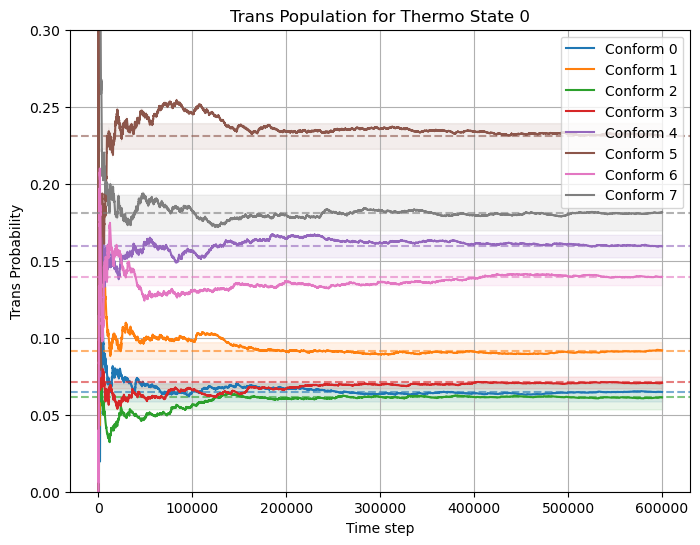

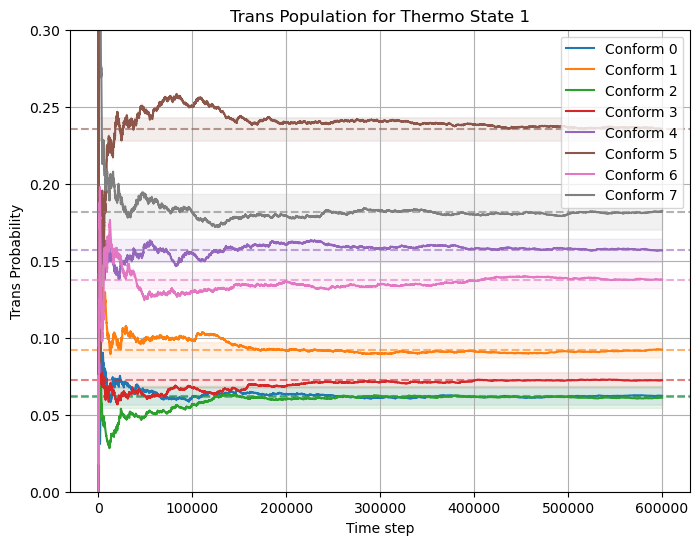

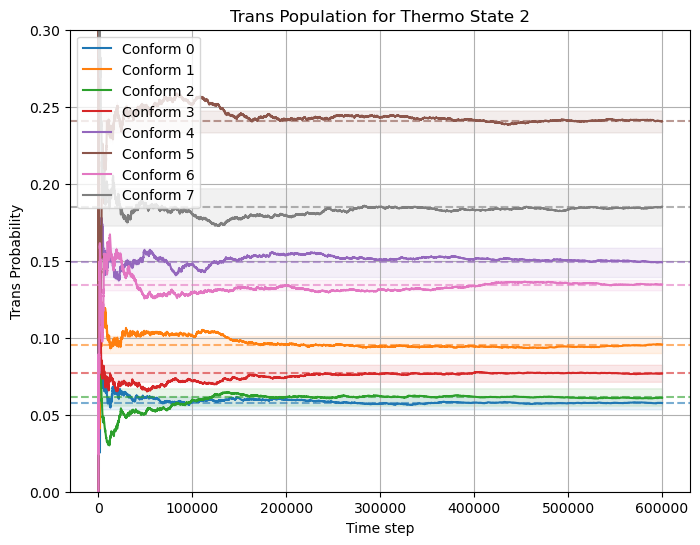

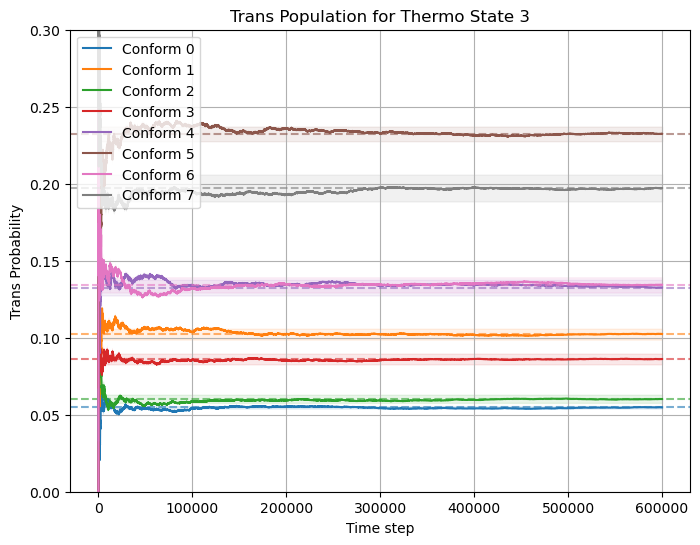

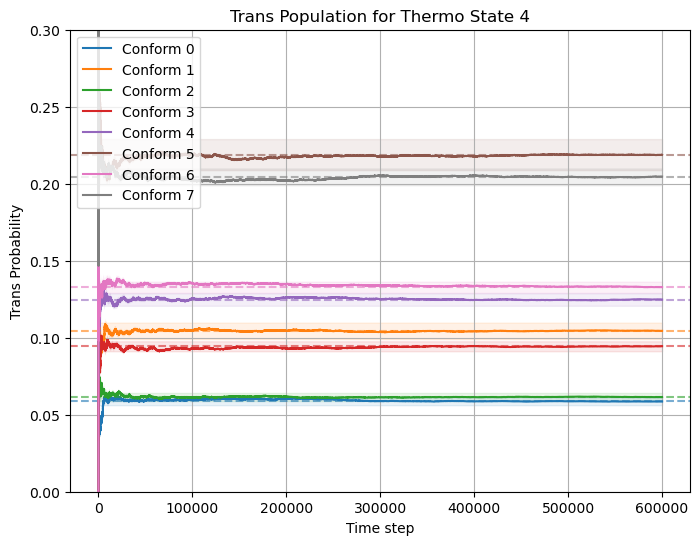

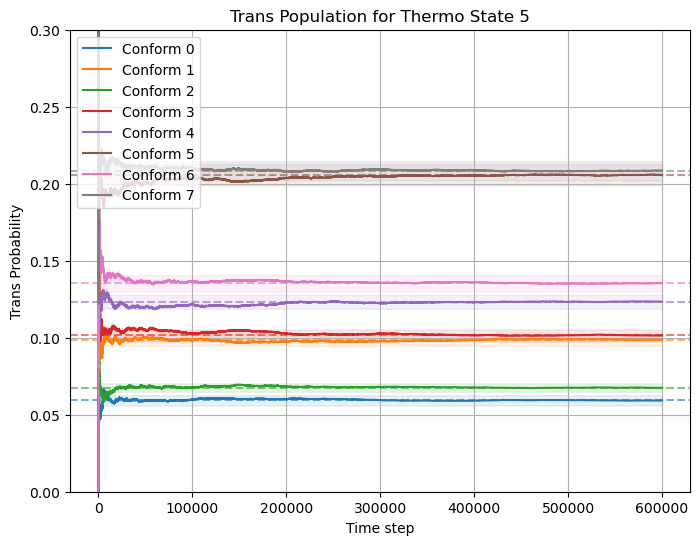

In [13]:
thermo_num = 6
conform_num = 8

for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(8, 6))
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        yerr = conform_thermo_all_population_err[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        plt.plot(x, y, label=f'Conform {conform}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Reference horizontal line
        ref_y = trans_refer_array[thermo, conform]
        ref_yerr = trans_refer_err_array[thermo, conform]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{conform}', alpha=0.6)
        plt.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{conform}', alpha=0.1)

    plt.title(f'Trans Population for Thermo State {thermo}')
    plt.xlabel('Time step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend(loc='best')
    #plt.tight_layout()
    plt.ylim(0, 0.3)
    plt.show()


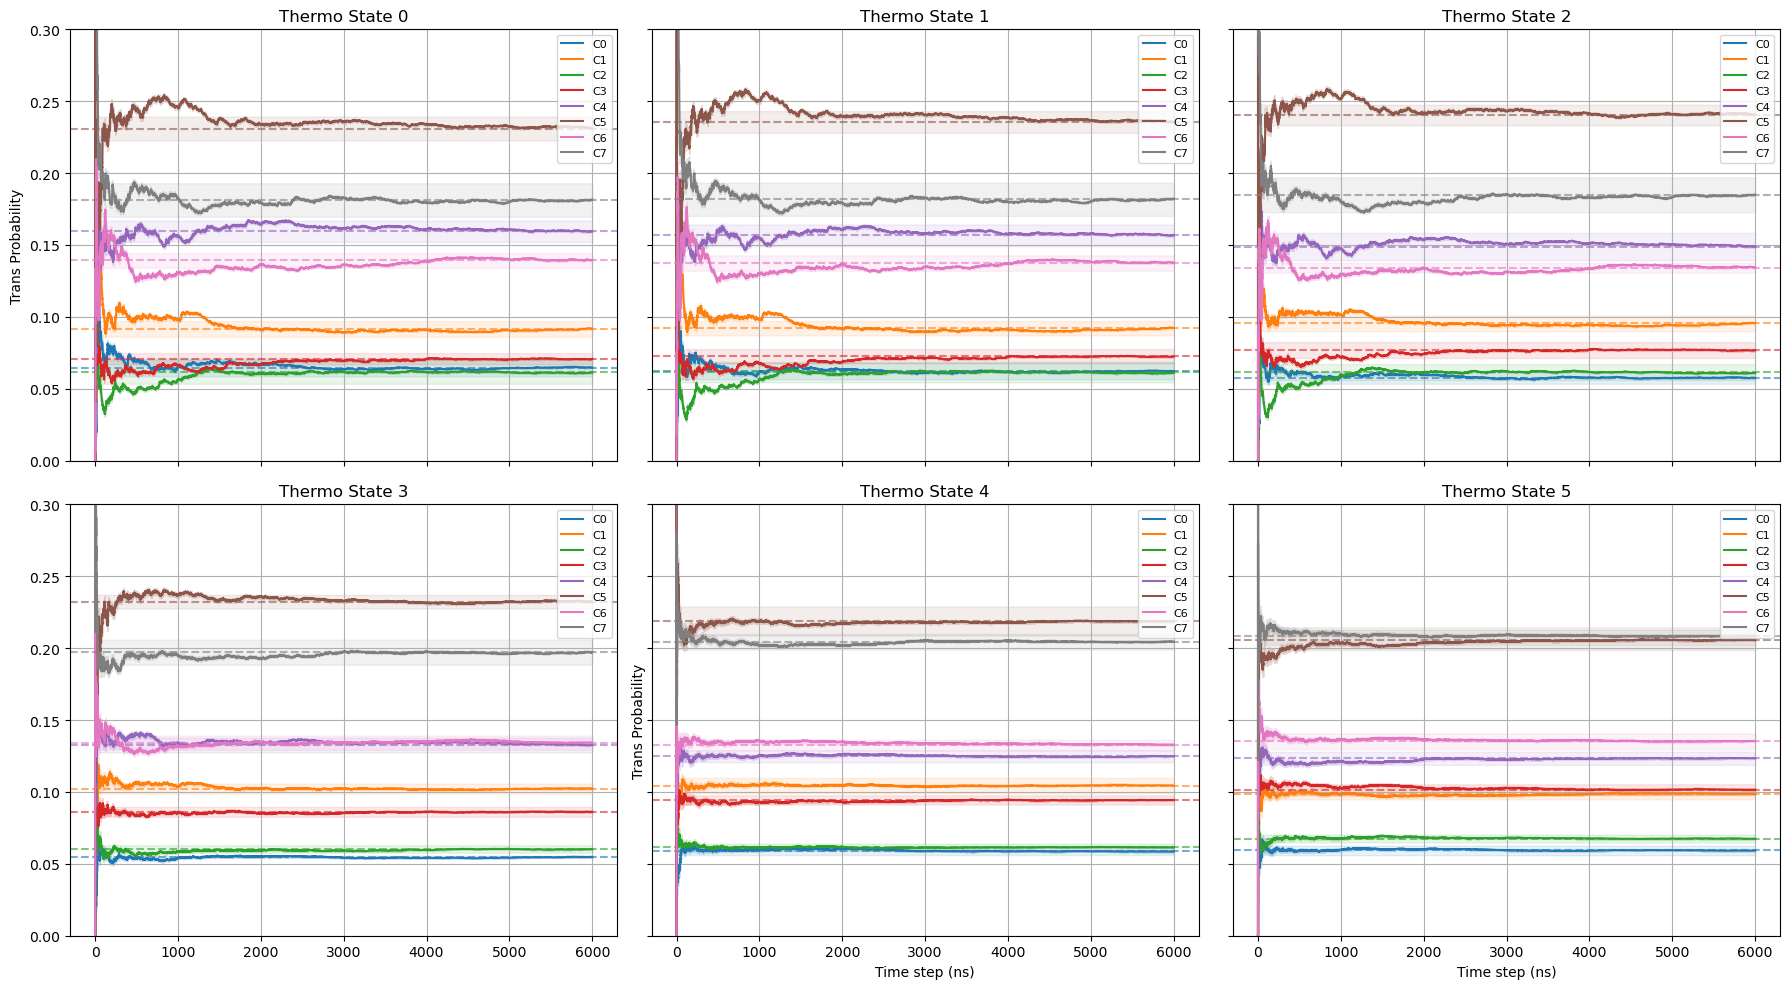

In [14]:
thermo_num = 6
conform_num = 8
time_in_ns = 0.01

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    ax = axes[thermo]
    
    for conform in range(conform_num):
        y = conform_thermo_all_population[thermo, conform, :]
        yerr = conform_thermo_all_population_err[thermo, conform, :]
        x = np.arange(len(y))

        ax.plot(x * time_in_ns, y, label=f'C{conform}', color=f'C{conform}')
        ax.fill_between(x * time_in_ns, y - yerr, y + yerr, alpha=0.2, color=f'C{conform}')

        # Reference horizontal line
        ref_y = trans_refer_array[thermo, conform]
        ref_yerr = trans_refer_err_array[thermo, conform]

        ax.axhline(y=ref_y, linestyle='--', color=f'C{conform}', alpha=0.6)
        ax.fill_between(x * time_in_ns, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{conform}', alpha=0.1)

    ax.set_title(f'Thermo State {thermo}')
    ax.set_ylim(0, 0.3)
    ax.grid(True)
    if thermo in [0, 4]:  # left column
        ax.set_ylabel('Trans Probability')
    if thermo >= 4:       # bottom row
        ax.set_xlabel('Time step (ns)')
    ax.legend(fontsize=8, loc='upper right')

# Hide unused subplot areas
for i in range(thermo_num, len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()


### Plot the ERROR

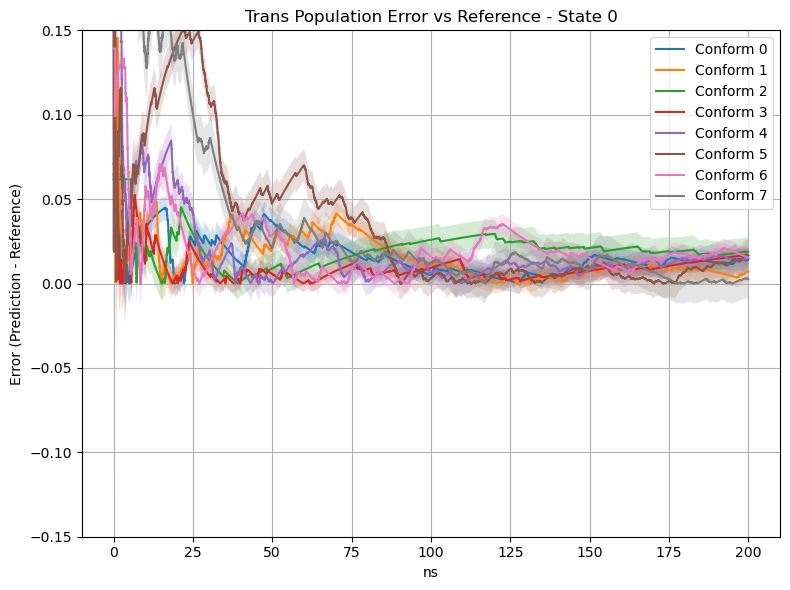

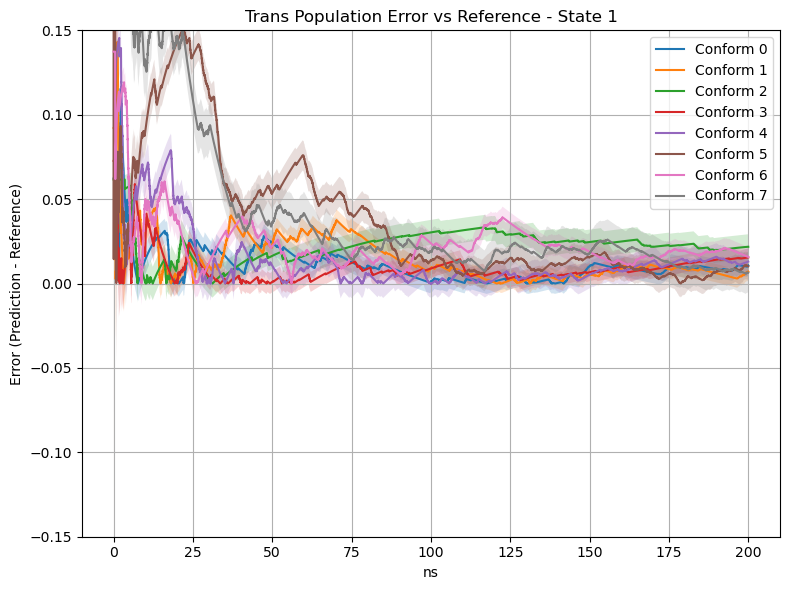

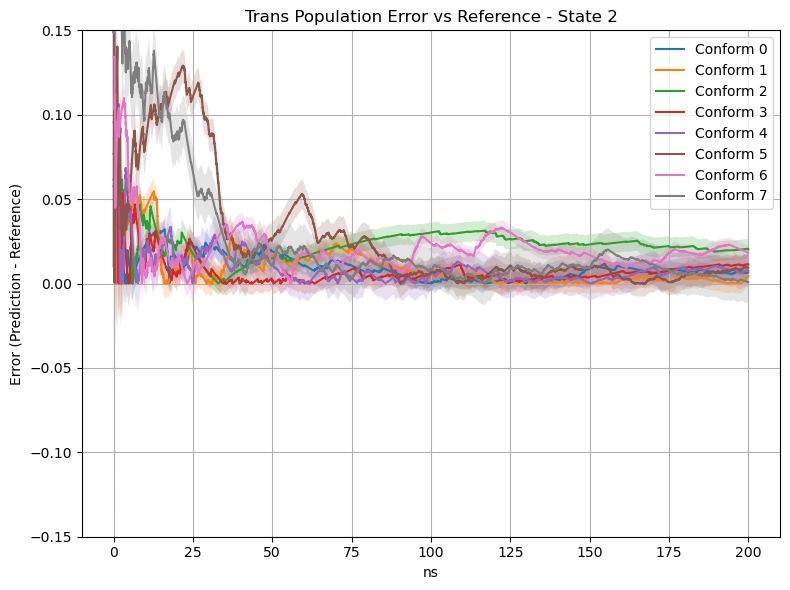

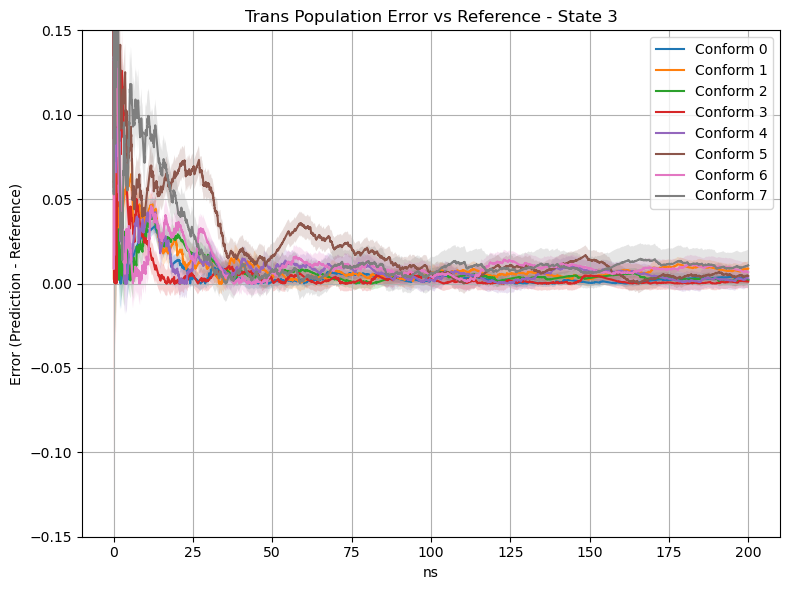

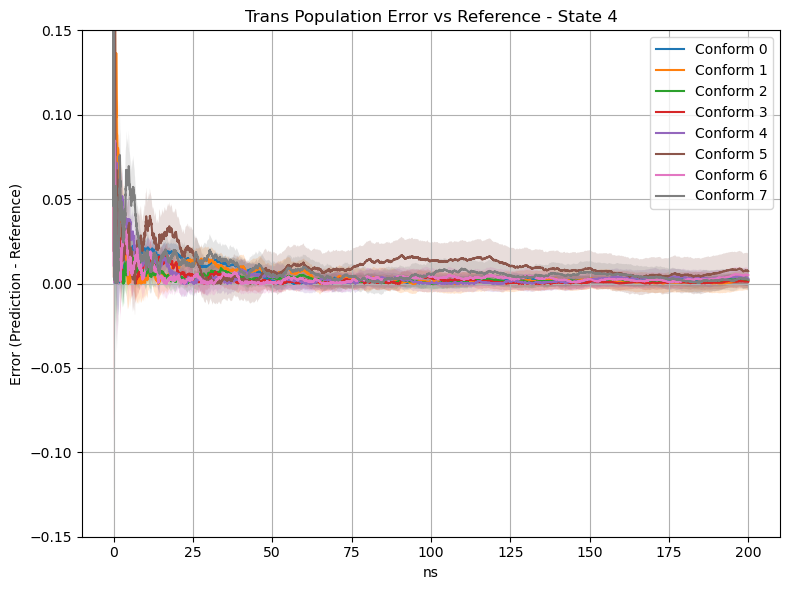

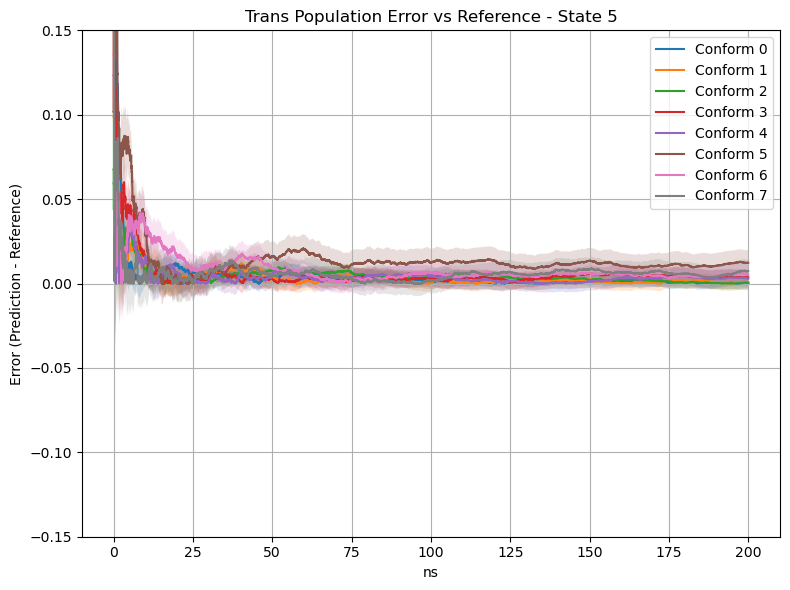

In [24]:
thermo_num = 6
conform_num = 8
dt_in_ns = 0.01 #10 ps
time_step_to_show = 20000 # 100 ns

for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(8, 6))
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        yerr = conform_thermo_all_population_err[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        # Reference horizontal line
        ref_y = trans_refer_array[thermo, conform]
        ref_yerr = trans_refer_err_array[thermo, conform]

        error = y - ref_y
        error = np.abs(error) # Take the absolute error 

        error_err = np.sqrt(
            yerr ** 2 +
            ref_yerr ** 2
        )

        plt.plot(x[:time_step_to_show] * dt_in_ns, error[:time_step_to_show], label=f'Conform {conform}')
        plt.fill_between(x[:time_step_to_show] * dt_in_ns, 
                         error[:time_step_to_show] - error_err[:time_step_to_show], 
                         error[:time_step_to_show] + error_err[:time_step_to_show], 
                         alpha=0.2)

    plt.title(f'Trans Population Error vs Reference - State {thermo}')
    plt.xlabel('ns')
    plt.ylabel('Error (Prediction - Reference)')
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.15, 0.15)
    plt.tight_layout()
    plt.show()


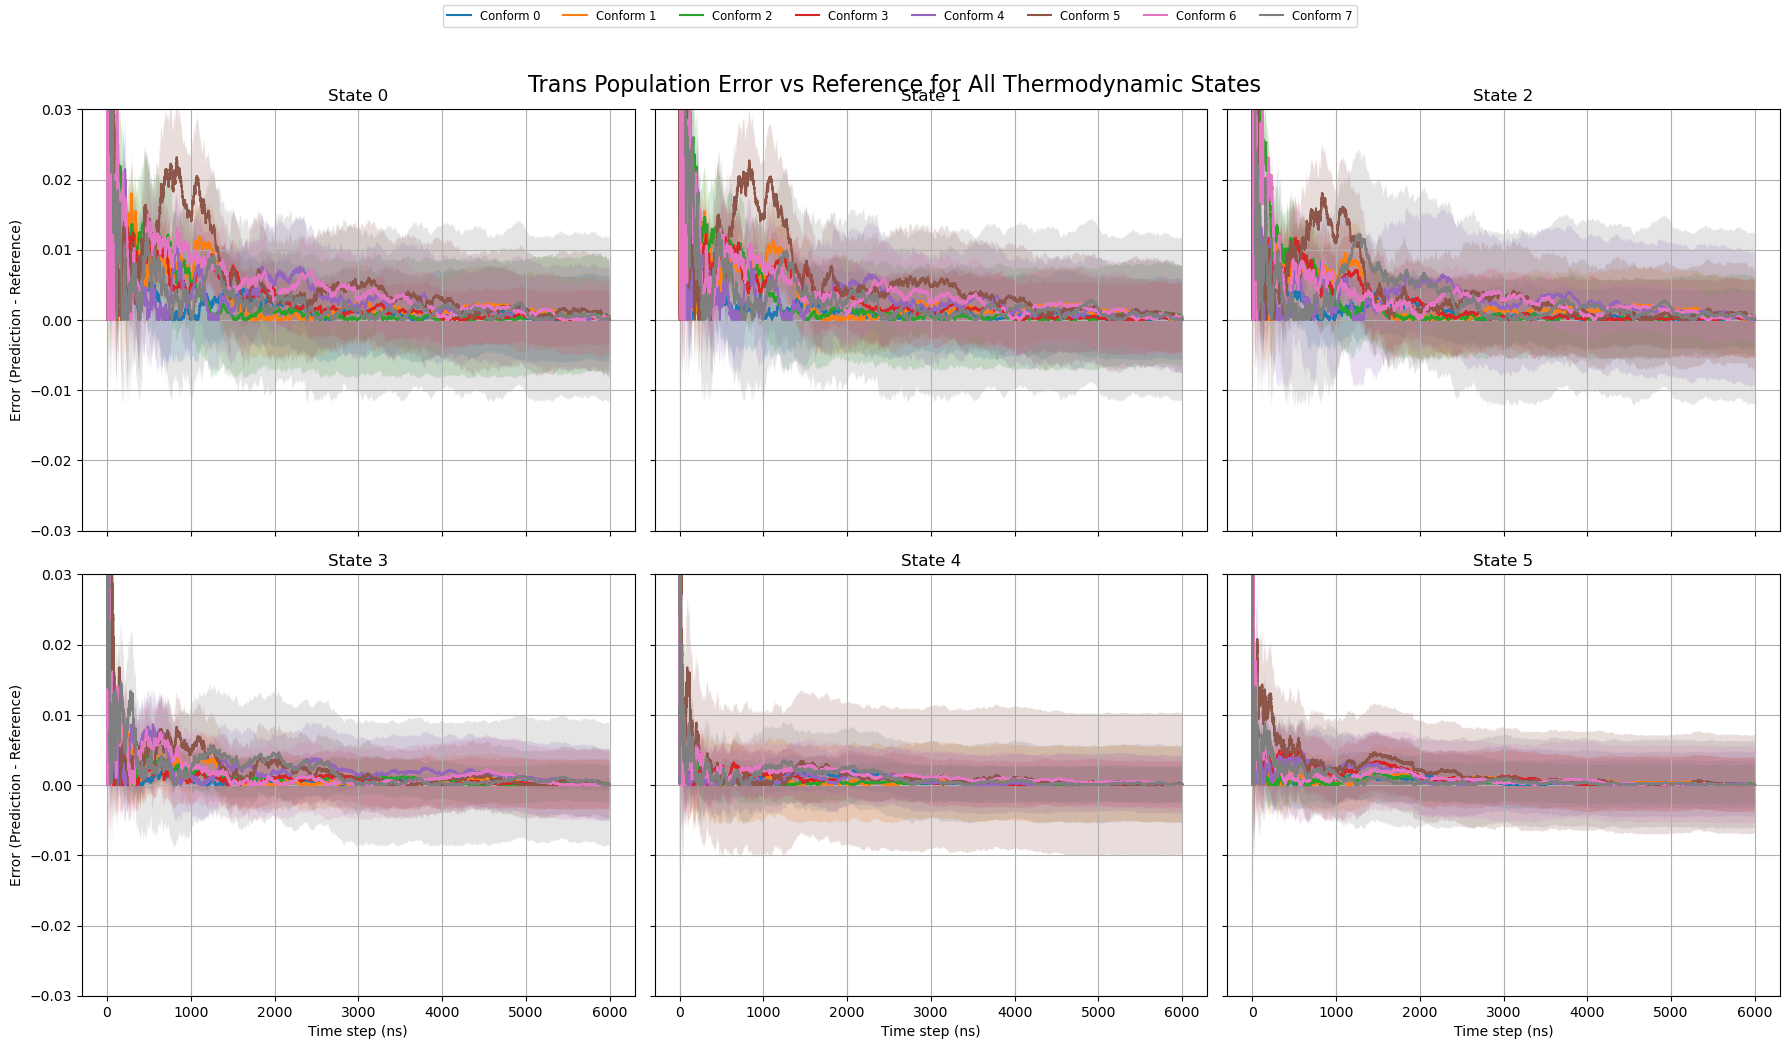

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

thermo_num = 6
conform_num = 8
time_in_ns = 0.01

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for thermo in range(thermo_num):
    ax = axes[thermo]

    for conform in range(conform_num):
        y = conform_thermo_all_population[thermo, conform, :]
        yerr = conform_thermo_all_population_err[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        ref_y = trans_refer_array[thermo, conform]
        ref_yerr = trans_refer_err_array[thermo, conform]

        error = y - ref_y
        error = np.abs(error) # Take the absolute error 
        
        error_err = np.sqrt(yerr**2 + ref_yerr**2)

        ax.plot(x * time_in_ns, error, label=f'Conform {conform}')
        ax.fill_between(x * time_in_ns, error - error_err, error + error_err, alpha=0.2)

    ax.set_title(f'State {thermo}')
    ax.grid(True)
    ax.set_ylim(-0.03, 0.03)
    if thermo >= 3:
        ax.set_xlabel('Time step (ns)')
    if thermo % 3 == 0:
        ax.set_ylabel('Error (Prediction - Reference)')

# Optional: Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=8, fontsize='small', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend
plt.suptitle('Trans Population Error vs Reference for All Thermodynamic States', fontsize=16)
plt.show()
